In [ ]:
# This notebook contains the test code and validation procedures for the LRG satellite statistical subtraction code

In [21]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
# from pythonds.basic.stack import Stack
from math import *
import random
from sklearn.neighbors import KDTree
import random
import pandas as pd
from tabulate import tabulate

In [25]:
# Define all relevant physical variables needed throughout the program, including:
# - number of LRG sources
# - number of survey (non-LRG) sources
# - coordinates for LRGs
# - coordinates for survey sources
# - projected radius from LRGs
# - LRG redshift
# - gmag and rmag for survey sources
# - gmag and rmag for LRGs
# - (g-r) color survey sources
# - (g-r) color for LRGs

# Number of LRG sources
lrg = 50

# Number of survey (non-LRG) sources
survey = 350

# Fake coordinates for LRG sources
random.seed(1)
ra_lrg = [np.random.uniform(0,5) for j in range(lrg)]
random.seed(2)
dec_lrg = [np.random.uniform(0,5) for j in range(lrg)]

# Fake coordinates for survey sources
random.seed(3)
ra_survey = [np.random.uniform(0,5) for j in range(survey)]
random.seed(4)
dec_survey = [np.random.uniform(0,5) for j in range(survey)]

# Redshift for LRG 
random.seed(0.2)
z = [np.random.uniform(0.1,0.5) for j in range(lrg)]

# Magnitudes for survey sources
random.seed(15)
gmag_survey = [np.random.uniform(14,29) for j in range(len(x1))]
random.seed(16)
rmag_survey = [np.random.uniform(13,24) for j in range(len(x1))]

gmag_survey = np.array(gmag_survey)
rmag_survey = np.array(rmag_survey)
color_survey = gmag_survey - rmag_survey

# Magnitudes for LRG sources
random.seed(20)
gmag_lrg = [np.random.uniform(17,23) for j in range(lrg)]
random.seed(21)
rmag_lrg = [np.random.uniform(16,21) for j in range(lrg)]

gmag_lrg = np.array(gmag_lrg)
rmag_lrg = np.array(rmag_lrg)
color_lrg = gmag_lrg - rmag_lrg

# Distance from which we are looking for satellites around the LRGs
distance = 1. # in Mpc
distance_kpc = distance * 10.**3. # in kpc

In [26]:
# cosmoCalc function to find scale (kpc_DA)
# This is a modified Python Code for this cosmological calculator (http://www.astro.ucla.edu/~wright/CC.python),
# Which is in turn modified from http: http://www.astro.ucla.edu/~wright/CosmoCalc.html. 

# I know this isn't ideal but for some reason the function won't import, even though it imports just fine in other
# files in the same directory

def cosmoCalcfunc(z):
    import numpy as np
    from math import sqrt
    from math import exp
    from math import sin
    from math import pi

# Calculate scale to get areas
    H0 = 69.6
    WM = 0.286
    WV = 0.714
# z = 0.209855

# initialize constants

    WR = 0.        # Omega(radiation)
    WK = 0.        # Omega curvaturve = 1-Omega(total)
    c = 299792.458 # velocity of light in km/sec
    Tyr = 977.8    # coefficent for converting 1/H into Gyr
    DTT = 0.5      # time from z to now in units of 1/H0
    DTT_Gyr = []  # value of DTT in Gyr
    age = 0.5      # age of Universe in units of 1/H0
    age_Gyr = []  # value of age in Gyr
    zage = 0.1     # age of Universe at redshift z in units of 1/H0
    zage_Gyr = [] # value of zage in Gyr
    DCMR = 0.0     # comoving radial distance in units of c/H0
    DCMR_Mpc = [] 
    DCMR_Gyr = []
    DA = 0.0       # angular size distance
    DA_Mpc = []
    DA_Gyr = []
    kpc_DA = []
    DL = 0.0       # luminosity distance
    DL_Mpc = []
    DL_Gyr = []   # DL in units of billions of light years
    V_Gpc = []
    a = 1.0        # 1/(1+z), the scale factor of the Universe
    az = 0.5       # 1/(1+z(object))

    h = H0/100.
    WR = 4.165E-5/(h*h)   # includes 3 massless neutrino species, T0 = 2.72528
    WK = 1-WM-WR-WV

    for j in range(len(z)):
        az = 1.0/(1+1.0*z[j])
        age = 0.
        n=1000         # number of points in integrals
        for i in range(n):
            a = az*(i+0.5)/n
            adot = sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
            age = age + 1./adot

        zage = az*age/n
        zage_Gyr.append((Tyr/H0)*zage)
        DTT = 0.0
        DCMR = 0.0

	# do integral over a=1/(1+z) from az to 1 in n steps, midpoint rule
        for i in range(n):
            a = az+(1-az)*(i+0.5)/n
            adot = sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
            DTT = DTT + 1./adot
            DCMR = DCMR + 1./(a*adot)

        DTT = (1.-az)*DTT/n
        DCMR = (1.-az)*DCMR/n
        age = DTT+zage
        age_Gyr.append(age*(Tyr/H0))
        DTT_Gyr.append((Tyr/H0)*DTT)
        DCMR_Gyr.append((Tyr/H0)*DCMR)
        DCMR_Mpc.append((c/H0)*DCMR)

	# tangential comoving distance

        ratio = 1.00
        x = sqrt(abs(WK))*DCMR
        if x > 0.1:
            if WK > 0:
                ratio =  0.5*(exp(x)-exp(-x))/x 
            else:
                ratio = sin(x)/x
        else:
            y = x*x
            if WK < 0: y = -y
            ratio = 1. + y/6. + y*y/120.
        DCMT = ratio*DCMR
        DA = az*DCMT
        DA_Mpc.append((c/H0)*DA)
        kpc_DA.append(DA_Mpc[j]/206.264806)
        DA_Gyr.append((Tyr/H0)*DA)
        DL = DA/(az*az)
        DL_Mpc.append((c/H0)*DL)
        DL_Gyr.append((Tyr/H0)*DL)

	# comoving volume computation

        ratio = 1.00
        x = sqrt(abs(WK))*DCMR
        if x > 0.1:
            if WK > 0:
                ratio = (0.125*(exp(2.*x)-exp(-2.*x))-x/2.)/(x*x*x/3.)
            else:
                ratio = (x/2. - sin(2.*x)/4.)/(x*x*x/3.)
        else:
            y = x*x
            if WK < 0: y = -y
            ratio = 1. + y/5. + (2./105.)*y*y
        VCM = ratio*DCMR*DCMR*DCMR/3.
        V_Gpc.append(4.*pi*((0.001*c/H0)**3)*VCM)
        
    return(DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc)

DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc = cosmoCalcfunc(z)

H:
[[ 0.  0.  0.  0.  0.  7.  5.  3.  6.  6.  3.  8.  3.]
 [ 0.  0.  0.  0.  3.  6.  1.  1.  2.  2.  4.  2.  1.]
 [ 0.  0.  0.  0.  5.  5.  4.  3.  9.  1.  4.  4.  0.]
 [ 0.  0.  0.  1.  1.  3.  7.  5.  2.  5.  5.  1.  0.]
 [ 0.  0.  0.  6.  6.  3.  6.  5.  3.  3.  4.  0.  0.]
 [ 0.  0.  2.  1.  7.  4.  5.  3.  3.  7.  2.  0.  0.]
 [ 0.  0.  2.  4.  1.  7.  4.  7.  5.  1.  0.  0.  0.]
 [ 0.  1.  3.  5.  4.  4.  4.  7.  3.  0.  0.  0.  0.]
 [ 0.  3.  5.  1.  5.  5.  5.  7.  7.  0.  0.  0.  0.]
 [ 1.  2.  1.  4.  2.  3.  5.  3.  3.  0.  0.  0.  0.]
 [ 0.  5.  4.  4.  5.  4.  4.  2.  0.  0.  0.  0.  0.]]
-------
sd:
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   2.16049383e-08   1.54320988e-08   9.25925926e-09
    1.85185185e-08   1.85185185e-08   9.25925926e-09   2.46913580e-08
    9.25925926e-09]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    9.25925926e-09   1.85185185e-08   3.08641975e-09   3.08641975e-09
    6.172

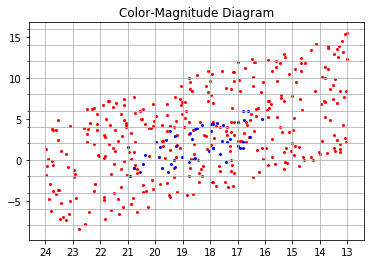

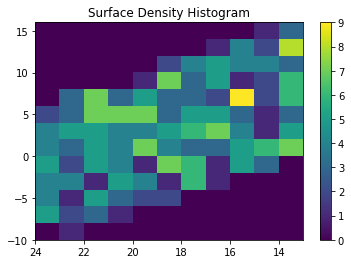

In [27]:
# Calculate SURFACE DENSITY (sd) as a function of color and magniude by making a 2D histogram and dividing by the area
# of the survey space

# Create a 2D histogram that creates evenly-spaced bins and counts the points in each bin
# H is the matrix with the number of points per bin
# xedges, yedges are the bounds of the bins

# Histogram bins
xedges = np.array([13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])
yedges = np.array([-10., -8., -6., -4., -2., 0., 2., 4., 6., 8., 10., 12., 14., 16.]) 

# creates histogram for survey sources; excluses LRGs
# H is the number of sources as a function of color and magnitude
H, xedges, yedges = np.histogram2d(rmag_survey, color_survey, bins=(xedges,yedges), normed=False)
print("H:")
print(H)
print('-------')

# Uses the numbers counted in the histogram to calculate a surface density: For each cell, the number of sources
# divided by the area 
sd = H/(25. * (3600.**2.)) # converts 25 square degrees to square arcseconds
print("sd:")
print(sd)
print('-------')

# Scatter plot of points with bin lines drawn
fig, ax = plt.subplots()
ax.set_xticks(xedges, minor=False)
ax.set_yticks(yedges, minor=True)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='minor')

plt.scatter(rmag_survey, color_survey, s = 4, color='red')
plt.scatter(rmag_lrg, color_lrg, s = 4, color='blue')
plt.gca().invert_xaxis()
plt.title("Color-Magnitude Diagram")
plt.show()

# color codes bins by surface density with color bar; should make sense when compared to scatter plot
# plt.imshow(sd, cmap=plt.cm.PuRd, extent=(xedges[0], xedges[len(xedges)-1], yedges[0], yedges[len(yedges)-1]))
# plt.colorbar(orientation='vertical')
# plt.title("Surface Density Histogram")
# plt.gca().invert_xaxis()
# plt.show()

plt.hist2d(rmag_survey, color_survey, bins=[xedges, yedges])
plt.colorbar(orientation='vertical')
plt.title("Surface Density Histogram")
plt.gca().invert_xaxis()
plt.show()

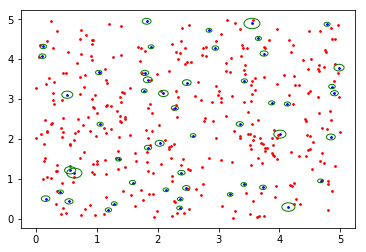

In [30]:
# Counting NEAR NEIGHBORS (nn) using KDTree
# Result is an array of the number of near neighbors each LRG has

dist = []
for i in range(len(kpc_DA)):
    dist.append((distance_kpc / kpc_DA[i]) * 1./3600.) 

# Plot RA/Dec plot with circles around LRGs
# Plots LRG sources and EDR sources
plt.scatter(ra_survey, dec_survey, s = 3, color='red')
plt.scatter(ra_lrg, dec_lrg, s = 3, color='blue')

# Draws circle of some radius around the LRG sources
# Circles too small to really see in the plot, but I have tested it with bigger radii to make sure it works if I
# ever need it.
circle = []
for i in range(len(x0)):
    circle = plt.Circle((ra_lrg[i],dec_lrg[i]), dist[i], color='green', fill=False)
    plt.gcf().gca().add_artist(circle)

plt.show()

# Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
zip_list_lrg = list(zip(ra_lrg, dec_lrg)) # Fake LRG sources
zip_list_survey = list(zip(ra_survey, dec_survey)) # Fake EDR sources

# Creates a tree of EDR sources
gal_tree = KDTree(zip_list_survey)

# returns a list of EDR sources that are within some radius r of an LRG
nn = gal_tree.query_radius(zip_list_lrg,r=dist,count_only=True)

# find indices of near neighbors
# creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
# arrays could be empty
ind = gal_tree.query_radius(zip_list_lrg,r=dist)

# Creates one list of number of near neighbors for every LRG (number of lists = number of LRGs)
# NEAR is the list of 2D arrays of satellite galaxies as a funciton of color and magnitude
near = []

for i in range(len(ind)):
    # Creates a zero array if there are no near neighbors
    if len(ind[i]) == 0:
        hist2d = np.zeros((len(xedges)-1,len(yedges)-1))
        near.append(hist2d)
    # Creates a 2D histogram for satellite galaxies
    else:
        hist2d, x_notuse, y_notuse = np.histogram2d(rmag_survey[ind[i]], color_survey[ind[i]], bins=(xedges, yedges), normed=False)
        near.append(hist2d)

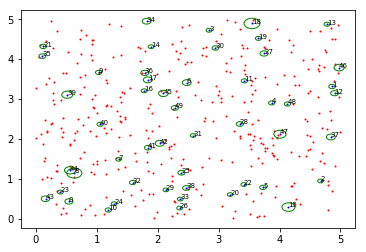

In [35]:
# Calculates NUMBER OF EXPECTED INTERLOPER GALAXIES (Nbkg) by first calculating the solid angle omega enclosed in 
# radius distance_kpc from the LRG. Then find the number of interloper galaxies by multiplying omega by the surface 
# density to find the number of interloper galaxies as a function of color and magnitude.

# Calculate solid angle omega for every radius ()
omega = []

for i in range(len(kpc_DA)):
    omega.append((np.pi * distance_kpc**2.)/(kpc_DA[i])**2.) # in square arcsec

# Multiply omega by the surface density
Nbkg = []

for i in range(len(omega)):
    Nbkg.append(sd * omega[i])
    
# Plots LRG sources and EDR sources
plt.scatter(ra_survey, dec_survey, s = 1, color='red')
plt.scatter(ra_lrg, dec_lrg, s = 1, color='blue')

# Plots circles around LRG sources 
circle = []
for i in range(len(x0)):
    circle = plt.Circle((ra_lrg[i],dec_lrg[i]), dist[i], color='green', fill=False)
    plt.gcf().gca().add_artist(circle)
    
# prints ID numbers next to LRG
# This will be slightly different when using real data because those sources have real ID numbers
a = np.arange(0,lrg)
for i, txt in enumerate(a):
    text = plt.annotate(txt, (ra_lrg[i],dec_lrg[i]))
    text.set_fontsize(7)

plt.show()

In [36]:
# Calculate NUMBER OF SATELLITE GALAXIES (Nsad) by subtracting interloper galaxies from near neighbor galaxies as a 
# function of color and magnitude.

Nsat = np.array(near) - np.array(Nbkg)

\begin{tabular}{rrrrr}
\hline
    &   number of interlopers &   number of near neighbors &   number of satellites &   projected radius \\
\hline
  0 &               0.193685  &                          0 &             -0.193685  &          0.0663605 \\
  1 &               0.129349  &                          0 &             -0.129349  &          0.0542303 \\
  2 &               0.0986024 &                          1 &              0.901398  &          0.0473483 \\
  3 &               0.102339  &                          0 &             -0.102339  &          0.0482371 \\
  4 &               0.112653  &                          0 &             -0.112653  &          0.0506096 \\
  5 &               0.13085   &                          0 &             -0.13085   &          0.054544  \\
  6 &               0.23042   &                          0 &             -0.23042   &          0.0723805 \\
  7 &               0.0904319 &                          0 &             -0.0904319 &          0.04

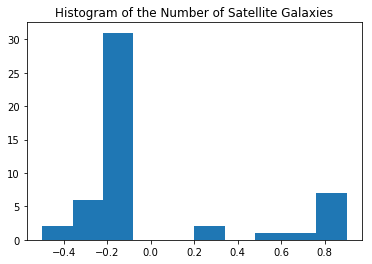

In [37]:
# Sum up satellite galaxies, expected interloper galaxies, and near neighbors
# Produce LaTeX code for a table with columns for projected radius, near neighbors, number of interlopers, number of
# satellite galaxies

sumsat = []
sumbkg = []
sumnear = []

for i in range(len(Nsat)):
    sumsat.append(np.sum(Nsat[i]))

for i in range(len(Nbkg)):
    sumbkg.append(np.sum(Nbkg[i]))
    
for i in range(len(near)):
    sumnear.append(np.sum(near[i]))

d = {'projected radius': dist, 'number of near neighbors': num, 'number of interlopers': sumbkg, 'number of satellites': sumsat}

df = pd.DataFrame(data=d)

print(tabulate(df, headers='keys', tablefmt='latex'))

meannear = np.mean(sumnear)
print("nearmean is", meannear)

sdnear = np.std(sumnear)
print("sdnear", sdnear)

meanbkg = np.mean(sumbkg)
print("meankbg is", meanbkg)

sdbkg = np.std(sumbkg)
print("sdbkg is", sdbkg)

meansat = np.mean(sumsat)
print("meansat is", meansat)

sdsat = np.std(sumsat)
print("sdsat is", sdsat)

plt.title("Histogram of the Number of Satellite Galaxies")
plt.hist(sumsat) #, bins=50)
plt.show()